# Exploratory Data Analysis

In this notebook we will carry out the Exploratory Data Analysis needed to understand the data we have available in our dataset, in order to create the most effective machine learning models possible. Our goal will be to analyse each variable's behaviour, with the aim of finding any possible outliers or missing values, as well as plotting this information for us to be easier to interpret it.

In [8]:
# importing the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# importing the dataset
df_raw = pd.read_csv("../data/raw/predictive_maintenance.csv")

In [3]:
# first five records of the dataset
df_raw.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# Understanding the dataset

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Our dataset is composed by 10000 records of a certain machine's production. It includes 10 columns, each one representing the values of some variables at the moment of production, as well as two target columns, one of them being a boolean variable -whether the machine failed or not- and the other being the kind of failure that the machine experimented. There are no null records in the dataset.

We will now proceed to analyse the information that each one of the columns provides us:

### 1. UDI

In [5]:
df_raw["UDI"].head()

0    1
1    2
2    3
3    4
4    5
Name: UDI, dtype: int64

This column is the unique identifier for each record of the dataset. We will not analyse this column as it will not provide us any relevant information.

### 2. Product ID & 3. Type

In [6]:
df_raw["Product ID"].head()

0    M14860
1    L47181
2    L47182
3    L47183
4    L47184
Name: Product ID, dtype: object

In [7]:
df_raw["Type"].head()

0    M
1    L
2    L
3    L
4    L
Name: Type, dtype: object

These two variables consist of a letter (L, M, H) and a serial number. These three letters represent the quality of the manufactured product, that is, L for low, M for medium and H for high

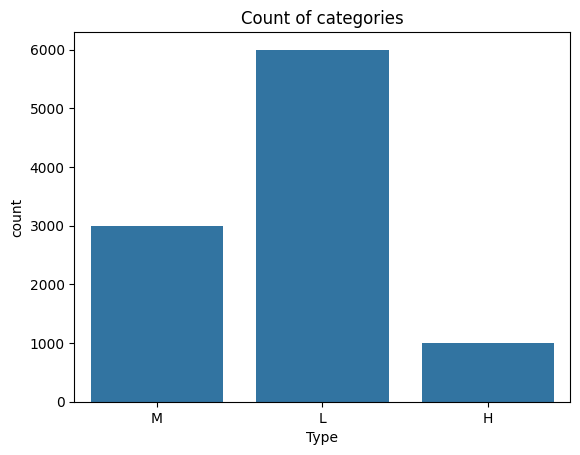

In [20]:
plt.title("Count of categories")
sns.countplot(data=df_raw, x=df_raw["Type"]);

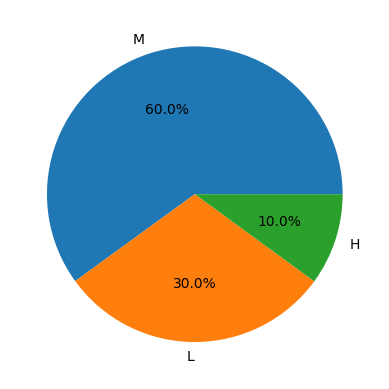

In [21]:
plt.pie(df_raw['Type'].value_counts(), labels=df_raw['Type'].unique(), autopct='%1.1f%%');

As we can see, the distribution of the different categories of this variable is not balanced. 60% of the records belong to medium quality products, 30% to low and 10% to high. This situation may need to be addressed before training any model, as this imbalance of categories may generate errors in the models.

### Air temperature [K]

In [22]:
df_raw["Air temperature [K]"].head()

0    298.1
1    298.2
2    298.1
3    298.2
4    298.2
Name: Air temperature [K], dtype: float64

This column provides us information about the temperature of the air in Kelvin. Values are normalised to a standard deviation of 2K around 300K